In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import re
from urllib.request import urlopen
from urllib.parse import urlparse
from urllib.error import HTTPError, URLError
from ssl import CertificateError
from socket import timeout as SocketTimeoutError
import sys

In [2]:
from settings import *

## Read Data

In [11]:
query = """
select *
from 
(select id, body, doc_type
from document
where doc_type = 'web'
limit 10) t1
UNION
(select id, body, doc_type
from document
where doc_type = 'twitter'
limit 10)
"""


documents = queryDB(query, 'smeros', '', 'sciArticles')
documents = documents.set_index('id')

In [12]:
def extractLinks(documents):

    urlRegex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    documents = documents.copy(deep=True)
    documents['body'] = documents['body'].apply(lambda x: re.findall(urlRegex, x)).to_frame()
    documents.rename(columns={'body': 'urls'}, inplace=True)
    
    return documents
extractLinks(documents)

,urls,doc_type
id,,
8cdd06a6-472e-11e5-8e33-42010af074fc,[],web
ff36bee6-530d-11e5-b5bc-42010af0793b,[http://t.co/jLpMnMaQWY],twitter
cc0ab8f8-4640-11e5-b738-42010af074fc,[http://t.co/PZRT2aWryd],twitter
e3d0ec44-4705-11e5-8dd2-42010af074fc,[],web
10b4ff52-4747-11e5-a5b0-42010af074fc,[],web
cc2259c0-4705-11e5-82cc-42010af074fc,[],web
7229175a-472e-11e5-b647-42010af074fc,[],web
c0385088-4705-11e5-b112-42010af074fc,[],web
d9c40736-4656-11e5-8e33-42010af074fc,[http://bit.ly/9OvIjO],twitter


In [13]:
def countLinks(documents):
    documents = documents.copy(deep=True)
    documents = extractLinks(documents)
    documents['urls'] = documents['urls'].apply(lambda x: len(x) if len(x)<linkLimit else "≥"+str(linkLimit))
    return documents.groupby(['doc_type','urls']).size()

def plotCountLinks(documents):
    count = countLinks(documents)
    docs = {}
    for doc_type in count.index.levels[0]:
        urls=[]
        for urlNum in count.index.levels[1]:
            urls.append(count.get((doc_type, urlNum),0))
        docs[doc_type]=urls

    
    both=pd.DataFrame(docs, index=count.index.levels[1])
    twitter=both['twitter'][lambda x: x!=0]
    web=both['web'][lambda x: x!=0]
 
    return both, twitter, web

bothCount, twitterCount, webCount = plotCountLinks(documents)

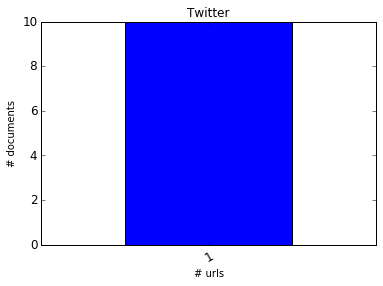

In [14]:
plt.xticks(rotation=70)
ax = twitterCount.plot.bar(fontsize=12, color='b', title='Twitter')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

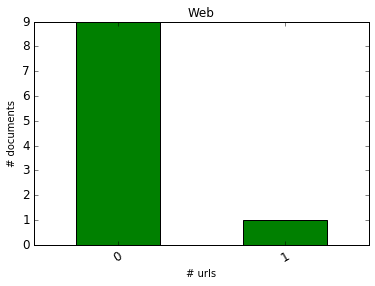

In [15]:
ax = webCount.plot.bar(fontsize=12, color='g', title='Web')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

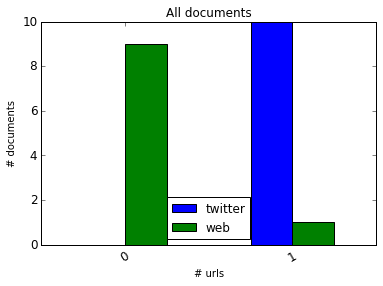

In [16]:
ax = bothCount.plot.bar(fontsize=12, color='bg', title='All documents')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

In [17]:
def flattenLinks(documents):
    documents = documents.copy(deep=True)
    documents = extractLinks(documents)
    
    documents = pd.DataFrame([(row[0], link, row[2]) for row in documents.itertuples() for link in row[1]], columns=['id', 'url', 'doc_type'])
    
    if (removeDuplicateLinks):
        documents = documents.drop_duplicates()
        
    return documents
    
flattenLinks(documents)

,id,url,doc_type
0,ff36bee6-530d-11e5-b5bc-42010af0793b,http://t.co/jLpMnMaQWY,twitter
1,cc0ab8f8-4640-11e5-b738-42010af074fc,http://t.co/PZRT2aWryd,twitter
2,d9c40736-4656-11e5-8e33-42010af074fc,http://bit.ly/9OvIjO,twitter
3,d9c3ceba-4656-11e5-8e33-42010af074fc,http://bit.ly/bRJn6h.,twitter
4,df300a4e-4656-11e5-8e33-42010af074fc,http://t.co/ytd74rP,twitter
5,c49c17e2-4640-11e5-b738-42010af074fc,http://t.co/XSMIHcfGv4,twitter
6,78c228d8-4a38-11e5-8389-42010af074fc,http://t.co/R94ngZTjmn,twitter
7,e95f4f5c-4656-11e5-8e33-42010af074fc,http://bit.ly/bFv1mN,twitter
8,d9c3bfd8-4656-11e5-8e33-42010af074fc,http://bit.ly/9wIiYL,twitter
9,90ad6bd6-472e-11e5-b1cc-42010af074fc,http://dotearth.blogs.nytimes.com/2012/09/20/t...,web


In [65]:
def resolveURLs(documents):

    documents = documents.copy(deep=True)
    documents = flattenLinks(documents)

    def resolve(url):
        resolved = {'resolvedURL':'', 'error':'', 'errorDesc':''}
        
        try:
            resolvedURL = urlopen(url,timeout=5).geturl()

            if(urlparse(resolvedURL).netloc.endswith('.ly')):
                resolved = {'resolvedURL':resolvedURL, 'error':'NoRedirectError', 'errorDesc':''}
            else:
                resolved = {'resolvedURL':resolvedURL, 'error':'NoError', 'errorDesc':''}
                
        except HTTPError as e:
            resolved = {'resolvedURL':url, 'error':'HTTPError', 'errorDesc':str(e.code)}
        except URLError as e:
            resolved = {'resolvedURL':url, 'error':'URLError', 'errorDesc':str(e)}
        except ConnectionResetError as e:
            resolved = {'resolvedURL':url, 'error':'ConnectionResetError', 'errorDesc':str(e)}
        except CertificateError as e:
            resolved = {'resolvedURL':url, 'error':'CertificateError', 'errorDesc':str(e)}
        except SocketTimeoutError as e:
            resolved = {'resolvedURL':url, 'error':'SocketTimeoutError', 'errorDesc':str(e)}
        except:
            print('!!!!NO CATCH!!!!', sys.exc_info())

        return pd.Series(resolved)
    
    documents = pd.concat((documents, documents['url'].apply(lambda x: resolve(x))), axis=1)
    return documents

resolveURLs(documents)

,id,url,doc_type,error,errorDesc,resolvedURL
0,ff36bee6-530d-11e5-b5bc-42010af0793b,http://t.co/jLpMnMaQWY,twitter,NoError,,http://www.greenmedinfo.com/blog/research-reve...
1,cc0ab8f8-4640-11e5-b738-42010af074fc,http://t.co/PZRT2aWryd,twitter,HTTPError,404,http://t.co/PZRT2aWryd
2,d9c40736-4656-11e5-8e33-42010af074fc,http://bit.ly/9OvIjO,twitter,NoError,,https://www.sciencedaily.com/releases/2010/06/...
3,d9c3ceba-4656-11e5-8e33-42010af074fc,http://bit.ly/bRJn6h.,twitter,NoError,,http://www.dairyreporter.com/R-D/Probiotics-ma...
4,df300a4e-4656-11e5-8e33-42010af074fc,http://t.co/ytd74rP,twitter,NoError,,http://www.beveragedaily.com/Markets/New-Kraft...
5,c49c17e2-4640-11e5-b738-42010af074fc,http://t.co/XSMIHcfGv4,twitter,NoError,,https://www.cdc.gov/pcd/issues/2014/14_0026.htm
6,78c228d8-4a38-11e5-8389-42010af074fc,http://t.co/R94ngZTjmn,twitter,HTTPError,302,http://t.co/R94ngZTjmn
7,e95f4f5c-4656-11e5-8e33-42010af074fc,http://bit.ly/bFv1mN,twitter,NoError,,https://www.sciencedaily.com/releases/2010/03/...
8,d9c3bfd8-4656-11e5-8e33-42010af074fc,http://bit.ly/9wIiYL,twitter,NoError,,http://www.bakeryandsnacks.com/Commodities/Sur...
9,90ad6bd6-472e-11e5-b1cc-42010af074fc,http://dotearth.blogs.nytimes.com/2012/09/20/t...,web,HTTPError,302,http://dotearth.blogs.nytimes.com/2012/09/20/t...


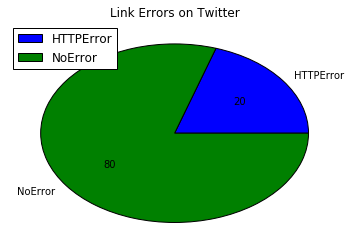

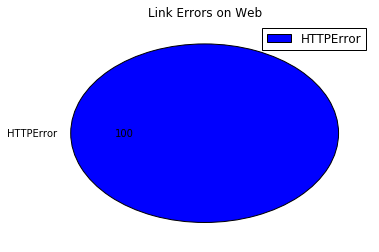

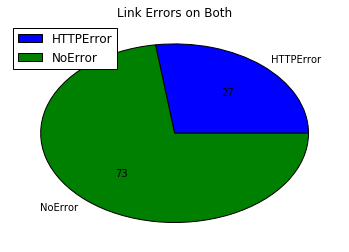

In [84]:
def plotLinkErrors(documents):
    documents = documents.copy(deep=True)
    documents = resolveURLs(documents)

    documents = documents[['doc_type','error']]
    
    twitter = documents[documents['doc_type']=='twitter']
    numOfLinks = twitter.shape[0]
    ax = twitter.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%.f', title='Link Errors on Twitter')
    ax.set_ylabel('')
    web = documents[documents['doc_type']=='web']
    numOfLinks = web.shape[0]
    ax = web.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%.f', title='Link Errors on Web')
    ax.set_ylabel('')
    numOfLinks = documents.shape[0]
    ax = documents.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%.f', title='Link Errors on Both')
    ax.set_ylabel('')
    
plotLinkErrors(documents)